In [1]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
import os
os.getcwd()

'/content'

In [5]:
import tensorflow as tf
from PIL import Image
import numpy as np

In [6]:
target = ['Heart','Oblong','Oval','Round','Square']

In [8]:
import random
import cv2
train_images = '../content/drive/MyDrive/FaceShape Dataset/training_set'
x_training = []
y_training = []
for (_,directories,_) in os.walk(train_images):
  for directory in directories:
    for(_,_,files) in os.walk(os.path.join(train_images,directory)):
      for filename in files:
        with open(os.path.join(train_images,directory,filename),'rb') as f:

          faceimage = cv2.imread(os.path.join(train_images,directory,filename))
          face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
          try:
            gray = cv2.cvtColor(faceimage,cv2.COLOR_BGR2GRAY)
          except:
            continue
          faces = face_cascade.detectMultiScale(gray)
          if len(faces)>0:
            x,y,w,h = faces[0]
          else:
            continue

          img = Image.open(f).convert('RGB').crop((x,y,x+w,y+h)).resize((380,380))
          arr = np.array(img)
          x_training.append(arr)
          y_training.append(directory)

          img_flip = img.transpose(method=Image.FLIP_LEFT_RIGHT)
          img_rotate = img.rotate(random.randint(-20,20))

          img_flip = np.array(img_flip)
          img_rotate = np.array(img_rotate)

          x_training.append(img_flip)
          x_training.append(img_rotate)

          y_training.append(directory)
          y_training.append(directory)



In [9]:
test_images = '../content/drive/MyDrive/FaceShape Dataset/testing_set'
x_test = []
y_test = []
for (_,directories,_) in os.walk(test_images):
  for directory in directories:
    for(_,_,files) in os.walk(os.path.join(test_images,directory)):
      for filename in files:
        with open(os.path.join(test_images,directory,filename),'rb') as f:
          faceimage = cv2.imread(os.path.join(test_images,directory,filename))
          face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
          try:
            gray = cv2.cvtColor(faceimage,cv2.COLOR_BGR2GRAY)
          except:
            continue
          faces = face_cascade.detectMultiScale(gray)
          if len(faces)>0:
            x,y,w,h = faces[0]
          else:
            continue

          img = Image.open(f).convert('RGB').crop((x,y,x+w,y+h)).resize((380,380))
          arr = np.array(img)
          x_test.append(arr)
          y_test.append(directory)

In [10]:
x_training = np.array(x_training)
y_training = np.array(y_training)


In [11]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [12]:
print(x_training.shape)
print(y_training.shape)

(11994, 380, 380, 3)
(11994,)


In [13]:
print(x_test.shape)
print(y_test.shape)

(997, 380, 380, 3)
(997,)


In [14]:
mean_r = np.mean(x_training[:, :, :, 0])  # Red 채널의 전체 mean 계산
mean_g = np.mean(x_training[:, :, :, 1])  # Green 채널의 전체 mean 계산
mean_b = np.mean(x_training[:, :, :, 2])  # Blue 채널의 전체 mean 계산

std_r = np.std(x_training[:, :, :, 0])  # Red 채널의 전체 std 계산
std_g = np.std(x_training[:, :, :, 1])  # Green 채널의 전체 std 계산
std_b = np.std(x_training[:, :, :, 2])  # Blue 채널의 전체 std 계산

In [15]:
print(f'mean: {mean_r},{mean_g},{mean_b}')
print(f'std: {std_r},{std_g},{std_b}')

mean: 159.80679614507162,122.67351405273274,104.61857584263046
std: 72.58244780862275,62.41943811258287,59.047168710327774


In [16]:
x_training[:,:,:,0] = (x_training[:,:,:,0] - mean_r)/float(std_r)
x_training[:,:,:,1] = (x_training[:,:,:,1] - mean_g)/float(std_g)
x_training[:,:,:,2] = (x_training[:,:,:,2] - mean_b)/float(std_b)

In [17]:
x_test[:,:,:,0] = (x_test[:,:,:,0] - mean_r)/float(std_r)
x_test[:,:,:,1] = (x_test[:,:,:,1] - mean_g)/float(std_g)
x_test[:,:,:,2] = (x_test[:,:,:,2] - mean_b)/float(std_b)

In [18]:
from keras import layers

In [19]:
#target = ['Heart','Oblong','Oval','Round','Square']
# 값 변환을 위한 dictionary
mapping_dict = {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3,'Square':4}

# 벡터화된 함수를 사용하여 배열의 값을 변경
vectorized_map = np.vectorize(mapping_dict.get)
y_training = vectorized_map(y_training)
y_test = vectorized_map(y_test)


In [20]:
from sklearn.utils import shuffle
x_training,y_training = shuffle(x_training,y_training)

In [21]:
from tensorflow.keras.utils import to_categorical

y_training = to_categorical(y_training)
y_test = to_categorical(y_test)

In [22]:
from keras.layers import Flatten
from keras.layers import Input
from tensorflow.keras.applications import EfficientNetB4
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
IMG_SIZE = 380
NUM_CLASSES = 5
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = EfficientNetB4(include_top=False, weights='imagenet',pooling='avg')(inputs)
base_model.trainable=False

x=base_model
outputs=Dense(NUM_CLASSES,activation='softmax',kernel_regularizer=l2(0.001))(x)

model = tf.keras.Model(inputs, outputs)
base_model.trainable=False
model.compile(
    optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 380, 380, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 1792)                │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           8,965 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,682,788 (67.45 MB)

 Trainable params: 17,557,581 (66.98 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [23]:
earlystopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10,restore_best_weights=True
)

In [24]:
epochs = 25
hist = model.fit(x=x_training,y=y_training, epochs=epochs, validation_data=(x_test,y_test), callbacks=[earlystopping])

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 512s 917ms/step - accuracy: 0.4546 - loss: 1.3112 - val_accuracy: 0.4915 - val_loss: 1.6590
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 539ms/step - accuracy: 0.7447 - loss: 0.6745 - val_accuracy: 0.6239 - val_loss: 1.1811
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 201s 535ms/step - accuracy: 0.8482 - loss: 0.4136 - val_accuracy: 0.6349 - val_loss: 1.1751
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 200s 534ms/step - accuracy: 0.9042 - loss: 0.2755 - val_accuracy: 0.6078 - val_loss: 1.5116
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 201s 537ms/step - accuracy: 0.9306 - loss: 0.2115 - val_accuracy: 0.6309 - val_loss: 1.5014
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 538ms/step - accuracy: 0.9395 - loss: 0.1812 - val_accuracy: 0.6499 - val_loss: 1.5766
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 200s 534ms/step - accuracy: 0.9535 - loss: 0.1392 - val_accuracy: 0.6720 - val_loss: 1.3090
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 200s 532ms/step - accuracy: 0.9665 -

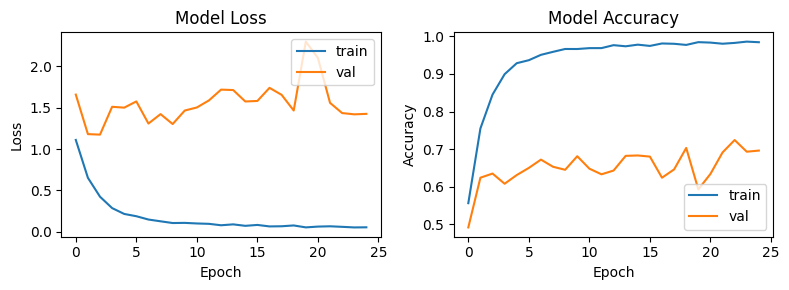

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))

# 훈련 손실 그래프
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [26]:
base_model.trainable = True

In [27]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
hist=model.fit(x=x_training,y=y_training, epochs=20, validation_data=(x_test,y_test), callbacks=[earlystopping])

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 428s 802ms/step - accuracy: 0.9925 - loss: 0.0282 - val_accuracy: 0.7462 - val_loss: 1.2883
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 200s 532ms/step - accuracy: 0.9979 - loss: 0.0169 - val_accuracy: 0.7543 - val_loss: 1.2770
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 200s 535ms/step - accuracy: 0.9983 - loss: 0.0138 - val_accuracy: 0.7563 - val_loss: 1.2662
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 201s 536ms/step - accuracy: 0.9983 - loss: 0.0122 - val_accuracy: 0.7472 - val_loss: 1.2124
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 201s 535ms/step - accuracy: 0.9992 - loss: 0.0097 - val_accuracy: 0.7503 - val_loss: 1.1888
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 537ms/step - accuracy: 0.9994 - loss: 0.0091 - val_accuracy: 0.7523 - val_loss: 1.2031
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 538ms/step - accuracy: 0.9994 - loss: 0.0083 - val_accuracy: 0.7472 - val_loss: 1.1715
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 201s 537ms/step - accuracy: 0.9997 -

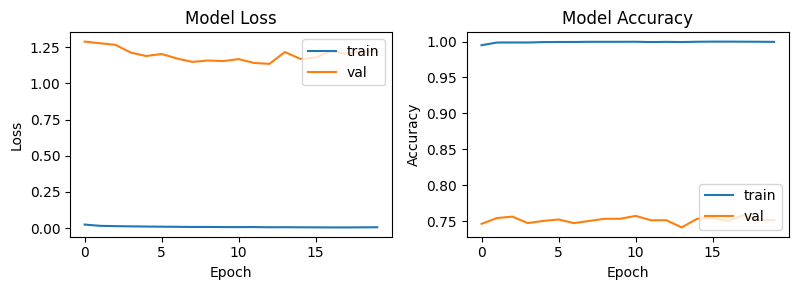

In [29]:
plt.figure(figsize=(8,3))

# 훈련 손실 그래프
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [30]:
model.save('model.h5')

# ref
- https://velog.io/@kyyle/Model-Optimization-1-%ED%9B%88%EB%A0%A8-%ED%9B%84-%EC%96%91%EC%9E%90%ED%99%94
- https://dacon.io/competitions/official/236082/codeshare/8441